## Library Imports

In [369]:
import pandas as pd
import missingno as msno

## Utility Functions

In [370]:
def dedupe(df: pd.DataFrame) -> int:
    before = len(df)
    df.drop_duplicates(inplace=True)
    
    return before - len(df)

## Data Reading

In [371]:
reviews_df = pd.read_csv('raw_dataset/AirlineScrappedReview_Cleaned.csv')

## Data Processing

### Reviews Table Data Processing

#### Reviews Table Data Cleaning

In [372]:
reviews_dupes = dedupe(reviews_df)
print(f'Duplicate Count: {reviews_dupes}')

Duplicate Count: 74


In [373]:
display(reviews_df.info())
display(reviews_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 3501 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3500 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2807 non-null   object 
 3   Rating           3501 non-null   int64  
 4   Verified         3501 non-null   object 
 5   Review_title     3501 non-null   object 
 6   Review_content   3501 non-null   object 
 7   Traveller_Type   3501 non-null   object 
 8   Class            3501 non-null   object 
 9   Start_Location   2807 non-null   object 
 10  End_Location     2807 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3441 non-null   float64
 13  Start_Longitude  3441 non-null   float64
 14  Start_Address    3441 non-null   object 
 15  End_Latitude     3402 non-null   float64
 16  End_Longitude    3402 non-null   float64
 17  End_Address      34

None

,Rating,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude
count,3501.000000,3441.000000,3441.000000,3402.000000,3402.000000
mean,4.764924,42.564281,-2.418618,40.429634,-1.353347
std,3.167312,17.193260,44.991376,18.904671,46.489936
min,1.000000,-37.666951,-123.182909,-37.814245,-123.179234
25%,2.000000,41.875562,-0.458780,38.954140,-0.458780
50%,4.000000,46.314475,-0.127765,46.314475,-0.127765
75%,8.000000,51.467739,11.048029,51.467739,11.048029
max,10.000000,65.011873,151.208285,64.145981,174.550610


In [374]:
first_word_mode = reviews_df['Review_content'].str.split().str[0].mode()[0]
print(f'Most Repeated First Word In Reviews: {first_word_mode}')

reviews_df.loc[reviews_df['Review_content'].str.startswith('Verified Review   '), 'Verified'] = 'Trip Verified'
reviews_df.loc[reviews_df['Review_content'].str.match(r'^❎(?: Unverified)?   '), 'Verified'] = 'Trip Unverified'

reviews_df['Review_content'] = reviews_df['Review_content'].str.replace(r'^(?:Verified Review|❎(?: Unverified)?)   ', '', regex=True)

Most Repeated First Word In Reviews: Verified


- The mode first word in `Review_content` indicates possible column interference and upon further exploration of the data, it was confirmed that the column indeed somestimes does include data rather meant for the `Verified` column.

Passanger_Name        1
Flying_Date        2546
Route               694
Rating                0
Verified              0
Review_title          0
Review_content        0
Traveller_Type        0
Class                 0
Start_Location      694
End_Location        694
Layover_Route      3017
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
dtype: int64

<Axes: >

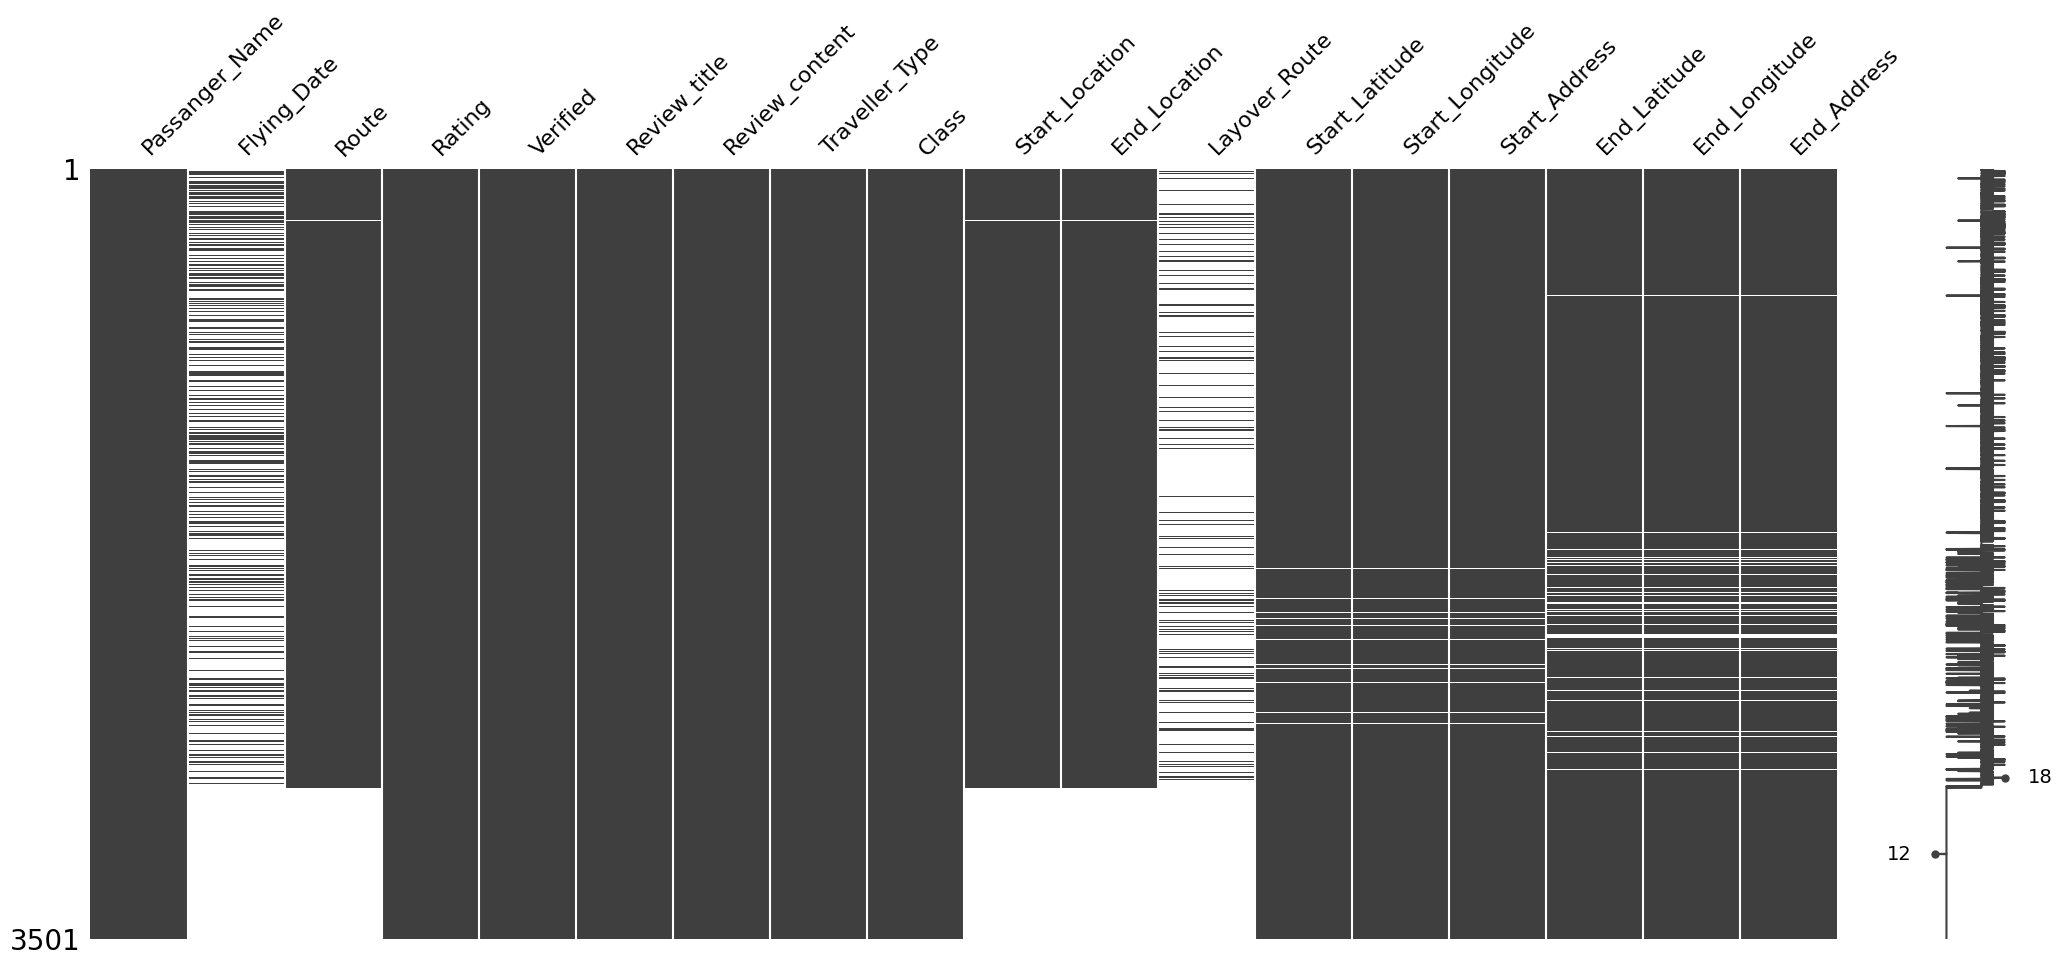

In [375]:
display(reviews_df.isnull().sum())
display(msno.matrix(reviews_df))

Initial Observations:<br />
- `Flying_Date` and `Layover_Route` have a majority of null values.<br />
- At a certain point, some specific columns start having null values regularly and systematically.<br />
- `Route` missing gap can't be inferred from `Start_Location` and `End_Location` as they share the same gap. Unless, location can be derived from address.<br />
- Latiture, longitude and address can possibly be inferred from location.

In [376]:
reviews_df.drop(columns=['Flying_Date'], inplace=True)
reviews_df['Layover_Route'].fillna('Direct', inplace=True)

In [377]:
sus_addr = reviews_df['Start_Address'].mode()[0]
sus_rows = reviews_df[reviews_df['Start_Address'] == sus_addr]
print(f'Suspicious Rows: {len(sus_rows)}')

idle_flights = reviews_df[reviews_df['Start_Address'] == reviews_df['End_Address']]
print(f'Idle Flights: {len(sus_rows)}')

sus_idle_flights = pd.merge(sus_rows, idle_flights, how='inner')
print(f'Suspicious Idle Flights: {len(sus_idle_flights)}')

Suspicious Rows: 694
Idle Flights: 694
Suspicious Idle Flights: 694


- As the MSNO matrix shows, `Flying_Date` isn't redeemable as the significant majority of its values are null. It was dropped.<br />
- `Layover_Route`, on the other hand, makes sense to have null as the majority of its values so it was simply filled with "Direct", meaning no transits.

In [378]:
display(reviews_df.nunique())

Passanger_Name     2759
Route              1541
Rating               10
Verified              3
Review_title       2570
Review_content     3501
Traveller_Type        6
Class                 5
Start_Location      332
End_Location        411
Layover_Route        51
Start_Latitude      282
Start_Longitude     282
Start_Address       284
End_Latitude        318
End_Longitude       318
End_Address         320
dtype: int64

In [379]:
na_start_addr = reviews_df[reviews_df['Start_Address'].isna()]
print('Null Start Addresses:')
display(na_start_addr.head(5))

na_end_addr = reviews_df[reviews_df['End_Address'].isna()]
print('Null End Addresses:')
display(na_end_addr.head(5))

max_loc_addr = reviews_df.groupby('Start_Location')['Start_Address'].nunique().max()
print(f'Maximum Unique Addresses Assigned To A Unique Location: {max_loc_addr}')

loc_diff = set(reviews_df['Start_Location']).symmetric_difference(set(reviews_df['End_Location']))
print(f'Locations That Are Only Either Start Or End: {len(loc_diff)}')

infer_start_addr = na_start_addr['Start_Location'].isin(reviews_df[~reviews_df['Start_Address'].isna()]['Start_Location'])
print(f'Inferabble Start Addresses From Start Locations: {infer_start_addr.sum()}')

infer_end_addr = na_end_addr['End_Location'].isin(reviews_df[~reviews_df['End_Address'].isna()]['End_Location'])
print(f'Inferabble End Addresses From End Locations: {infer_end_addr.sum()}')

Null Start Addresses:


,Passanger_Name,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
1019,Roger Stone,HKG to LHR,8,Trip Verified,an enjoyable experience,I thought it time BA deserved some compliments...,Business,Premium Economy,Hong Kong - International Airport (HKIA),London Heathrow,Direct,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro..."
1168,Carlos Arenas,Edimbourgh to London Gatwick,3,Trip Verified,I end up with mix feelings,I have traveled several times with British Air...,Couple Leisure,Economy Class,Edimbourgh,London Gatwick,Direct,NaN,NaN,NaN,51.154108,-0.182312,"London Gatwick Airport, Perimeter Road East, L..."
1360,John Barry,Zakinthos to London Heathrow,8,Trip Verified,very good flight again,Zakinthos to London Heathrow. Poor check in at...,Family Leisure,Business Class,Zakinthos,London Heathrow,Direct,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro..."
1737,Vincent Borlaug,IAD to BCN via LHR,10,Trip Verified,still my first choice,Washington to Barcelona return via London (pre...,Solo Leisure,Premium Economy,Washington DC - Dulles International,Barcelona,London - Heathrow,NaN,NaN,NaN,41.382894,2.177432,"Barcelona, Barcelonès, Barcelona, Catalunya, 0..."
1749,J Hicklin,SFO to JNB via LHR,6,Trip Verified,as different as night and day,San Francisco to Johannesburg via London. The ...,Solo Leisure,Business Class,"San Francisco - International Airport, SA",Johannesburg - OR Tambo International Airport,London - Heathrow,NaN,NaN,NaN,-26.136013,28.244977,"O.R. Tambo International Airport, Elgin Street..."


Null End Addresses:


,Passanger_Name,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
357,J Prescott,Dubai to London Heaathrow,6,Trip Verified,just used the new Club World,We've just used the new Club World for the fir...,Couple Leisure,Business Class,Dubai,London Heaathrow,Direct,25.265347,55.292491,"دبي, الإمارات العربية المتحدة",NaN,NaN,NaN
575,A Maharif,doha to londonDoha to London,9,Trip Verified,Surprisingly good flight,"Doha to London. Surprisingly good flight, onti...",Family Leisure,Economy Class,doha,londonDoha,Direct,25.285633,51.526416,"الدوحة, قطر",NaN,NaN,NaN
1074,Wolfgang Bernhart,Frankfurt to London Cuty,1,Trip Verified,There is not a hotline,When I checked in the evening before for the 7...,Business,Economy Class,Frankfurt,London Cuty,Direct,50.110644,8.682092,"Frankfurt am Main, Hessen, Deutschland",NaN,NaN,NaN
1363,John Barry,London Heathrow to Zakinthos,9,Trip Verified,kind and chatty with us,London Heathrow to Zakinthos. From parking mee...,Family Leisure,Business Class,London Heathrow,Zakinthos,Direct,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",NaN,NaN,NaN
1652,Ron Baker,LHR to GVA,2,Trip Verified,not what one expects from Business Class,Flew from London Heathrow to Geneva. Fast Trac...,Couple Leisure,Business Class,London Heathrow,Geneva - Geneva-Cointrin International Airport,Direct,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",NaN,NaN,NaN


Maximum Unique Addresses Assigned To A Unique Location: 1
Locations That Are Only Either Start Or End: 219
Inferabble Start Addresses From Start Locations: 0
Inferabble End Addresses From End Locations: 0


- An address can not be assigned to more than one location; 1:1 relationship between `Start_Location` and `Start_Address`.
- Can not only depend on either start or end, must depend on both as their set difference isn't empty.
- This was a failed attempt to infer `Start_Address` from start location as null addresses' locations do not have other non-null addresses.
- - -
- The tables demonstrate that the lack of addresses is sometimes attributed to a typo in specifying the locations.
- **UNSURE** It would be unwise to impute the latitude and longitudes according to a global statistic and not something local to for ex. location, which unfortunately lacks non-null replacements for null addresses / latitiudes / logitudes.
- Very little can be done to resolve that without the aid of something like an LLM but we reckon that exceeds the scope of this task.

In [380]:
na_loc = reviews_df[(reviews_df['Start_Location'].isna()) & (reviews_df['Start_Address'] != sus_addr)]
print(f'Null Locations That Are Not Of A Suspicious Address: {len(na_loc)}')

Null Locations That Are Not Of A Suspicious Address: 0


- Upon investigation, it was discovered that the anomalous bottom gap has a stray value near the top of the table that causes the null route and location.

In [381]:
reviews_df = reviews_df[reviews_df['Start_Address'] != sus_addr]
reviews_df.dropna(subset=['Start_Address', 'End_Address'], inplace=True)

- It was decided to drop the rows that contain the anomalous address as it is illogical to have the same origin and destination for a flight.
- It was decided to drop the missing addresses due to their insignificant count, in order to ensure data availability across all columns.

Passanger_Name     0
Route              0
Rating             0
Verified           0
Review_title       0
Review_content     0
Traveller_Type     0
Class              0
Start_Location     0
End_Location       0
Layover_Route      0
Start_Latitude     0
Start_Longitude    0
Start_Address      0
End_Latitude       0
End_Longitude      0
End_Address        0
dtype: int64

<Axes: >

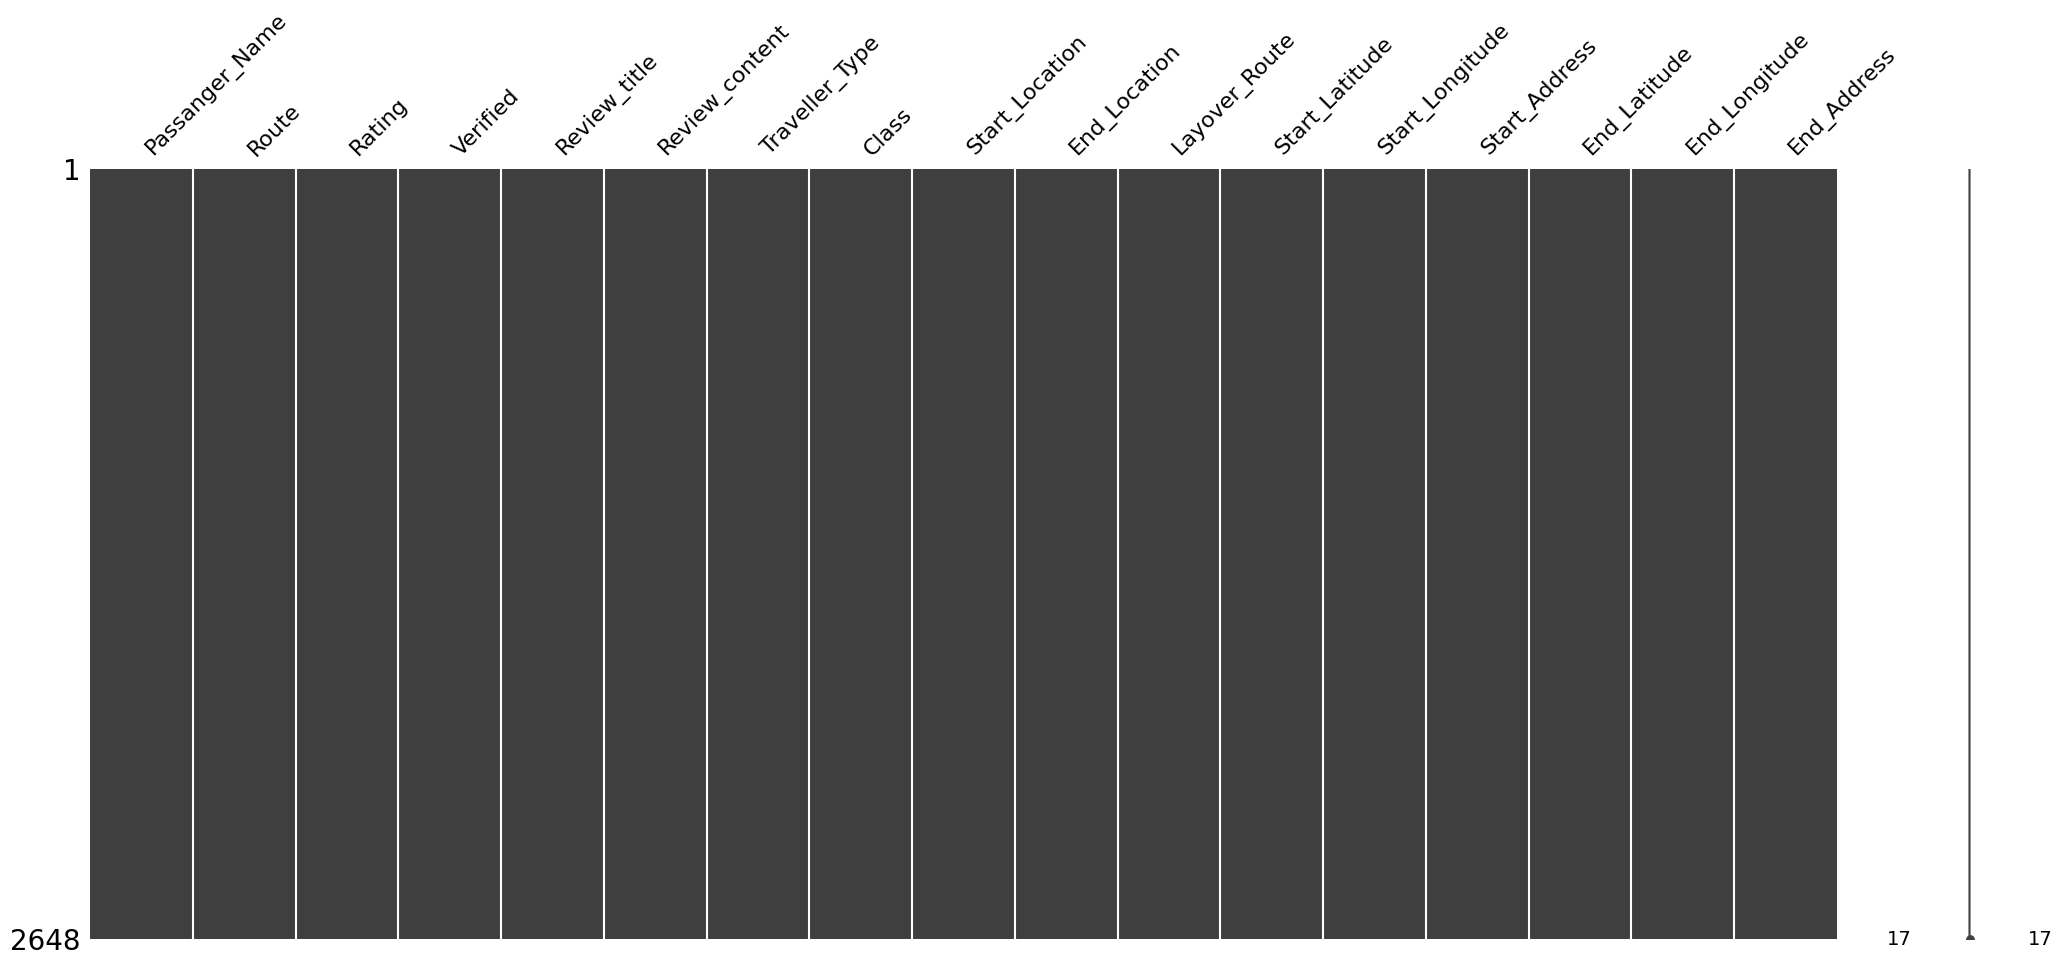

In [382]:
display(reviews_df.isnull().sum())
msno.matrix(reviews_df)

- As a side observation, the row lacking the `Passanger_Name` field was removed as a side effect of the previous removal operations concerning the anomalous address and the other missing addresses.

In [383]:
reviews_df.rename(columns={
    'Passangar_Name': 'passenger_name',
    'Route': 'route',
    'Rating': 'rating',
    'Verified': 'verified',
    'Review_title': 'review_title',
    'Review_content': 'review_content',
    'Traveller_Type': 'traveller_type',
    'Class': 'class',
    'Start_Location': 'start_location',
    'End_Location': 'end_location',
    'Layover_Route': 'layover_route',
    'Start_Latitute': 'start_latitude',
    'Start_Longitude': 'start_longitude',
    'Start_Address': 'start_address',
    'End_Latitute': 'end_latitude',
    'End_Longitude': 'end_longitude',
    'End_Address': 'end_address'
}, inplace=True)

- Column names were changed to use a more consistent and conventional case.

In [ ]:
reviews_df.to_csv('processed_dataset/airline_reviews.csv', index=False)

### Comments Table Data Processing

#### Comments Table Data Cleaning

In [385]:
comments_df = pd.read_csv('raw_dataset/Customer_comment.csv')

In [386]:
comments_dupes = dedupe(comments_df)
print(f'Duplicate Count: {comments_dupes}')

Duplicate Count: 0


In [387]:
display(comments_df.info())
display(comments_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9424 non-null   int64 
 1   flight_number             9424 non-null   int64 
 2   origin_station_code       9424 non-null   object
 3   destination_station_code  9424 non-null   object
 4   scheduled_departure_date  9424 non-null   object
 5   arrival_delay_group       9424 non-null   object
 6   departure_delay_group     9424 non-null   object
 7   entity                    9424 non-null   object
 8   verbatim_text             9424 non-null   object
 9   seat_factor_band          9424 non-null   object
 10  ques_verbatim_text        9424 non-null   object
 11  loyalty_program_level     6920 non-null   object
 12  fleet_type_description    9424 non-null   object
 13  fleet_usage               9424 non-null   object
 14  response_group          

None

,Unnamed: 0,flight_number
count,9424.000000,9424.000000
mean,4711.500000,1741.573430
std,2720.618802,1550.550037
min,0.000000,2.000000
25%,2355.750000,614.000000
50%,4711.500000,1286.000000
75%,7067.250000,2261.000000
max,9423.000000,6375.000000


Unnamed: 0                     0
flight_number                  0
origin_station_code            0
destination_station_code       0
scheduled_departure_date       0
arrival_delay_group            0
departure_delay_group          0
entity                         0
verbatim_text                  0
seat_factor_band               0
ques_verbatim_text             0
loyalty_program_level       2504
fleet_type_description         0
fleet_usage                    0
response_group                 0
sentiments                     0
transformed_text            1019
dtype: int64

<Axes: >

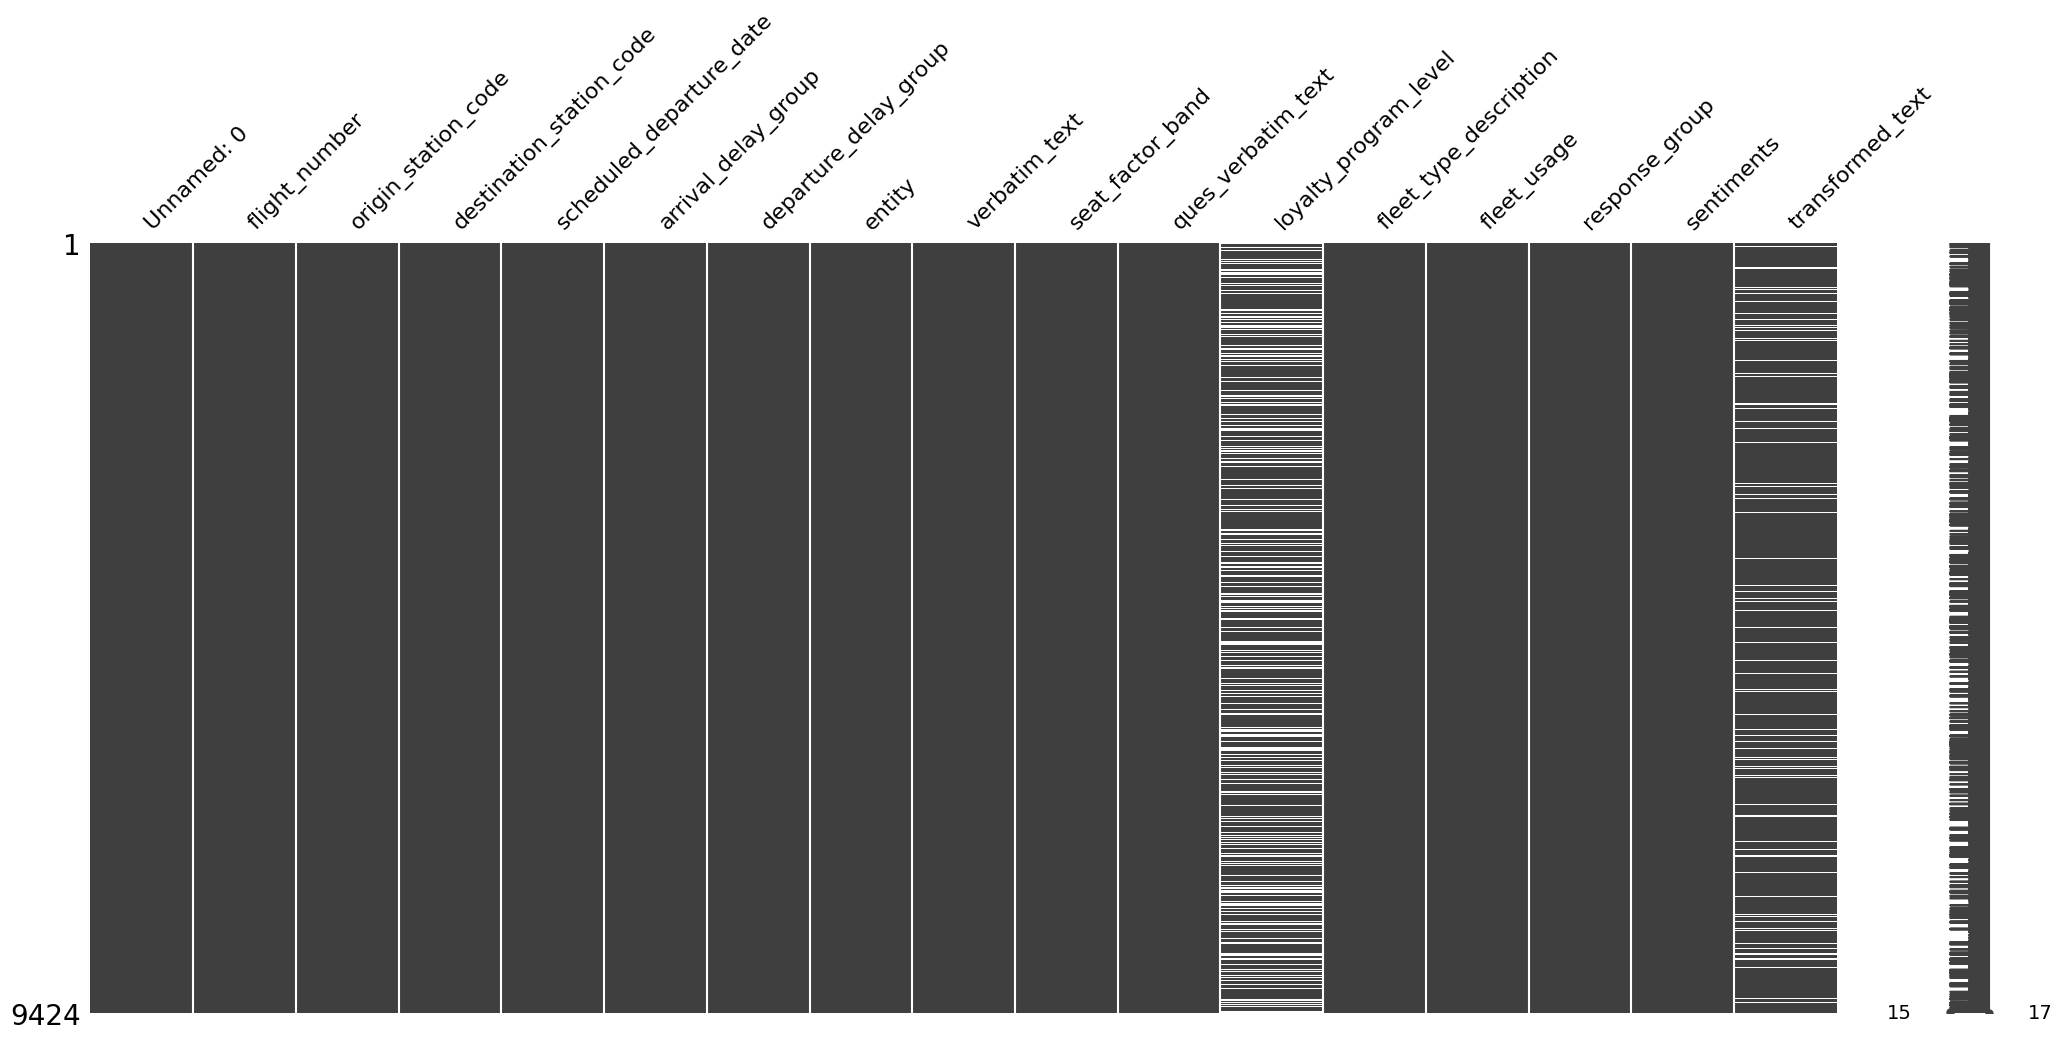

In [388]:
display(comments_df.isnull().sum())
display(msno.matrix(comments_df))

In [389]:
display(comments_df.nunique())

Unnamed: 0                  9424
flight_number               3001
origin_station_code          195
destination_station_code     192
scheduled_departure_date      30
arrival_delay_group            2
departure_delay_group          2
entity                         4
verbatim_text               8013
seat_factor_band               4
ques_verbatim_text             1
loyalty_program_level          7
fleet_type_description        22
fleet_usage                    2
response_group                 3
sentiments                     2
transformed_text            7609
dtype: int64

In [390]:
comments_df.drop(columns=['Unnamed: 0', 'ques_verbatim_text'], inplace=True)

- The first column was dropped as it contains a serial ID, redundant to our needs.
- `ques_verbatim_text` was dropped as it contains the same value for all rows.

In [391]:
loyalty_rpgrp = comments_df[comments_df['loyalty_program_level'].isnull()]['response_group'].unique()
print(f'Response Groups Where Loyalty Is Null: {', '.join(loyalty_rpgrp)}')

comments_df['loyalty_program_level'].fillna(comments_df['response_group'], inplace=True)

Response Groups Where Loyalty Is Null: non-member


- Null values in `loyalty_program_level` are attributed to an actual lack of a loyalty level due to lack of membership, so they were filled accordingly.

In [392]:
transtext_vertext = comments_df[comments_df['transformed_text'].isnull()]['verbatim_text'].unique()
print(f'Verbatim Texts Where Transformed Text Null: {', '.join(transtext_vertext)}')

comments_df['transformed_text'].fillna('', inplace=True)

Verbatim Texts Where Transformed Text Null: no., No., N/A., ., .., Not., Other., There was not any…., More., n/a., No, that is it!., ..., Y., No!., NO., There was not any., there was not any., I did not have any., n.a., N/a., That is all., no,., N/., No…., We did not have any., N-A., <:)>., Not at all., 1/3 of a can?.


- Null values in `transformed_text` are attributed to an actual lack of a response, so they were filled to reflect that.

flight_number               0
origin_station_code         0
destination_station_code    0
scheduled_departure_date    0
arrival_delay_group         0
departure_delay_group       0
entity                      0
verbatim_text               0
seat_factor_band            0
loyalty_program_level       0
fleet_type_description      0
fleet_usage                 0
response_group              0
sentiments                  0
transformed_text            0
dtype: int64

<Axes: >

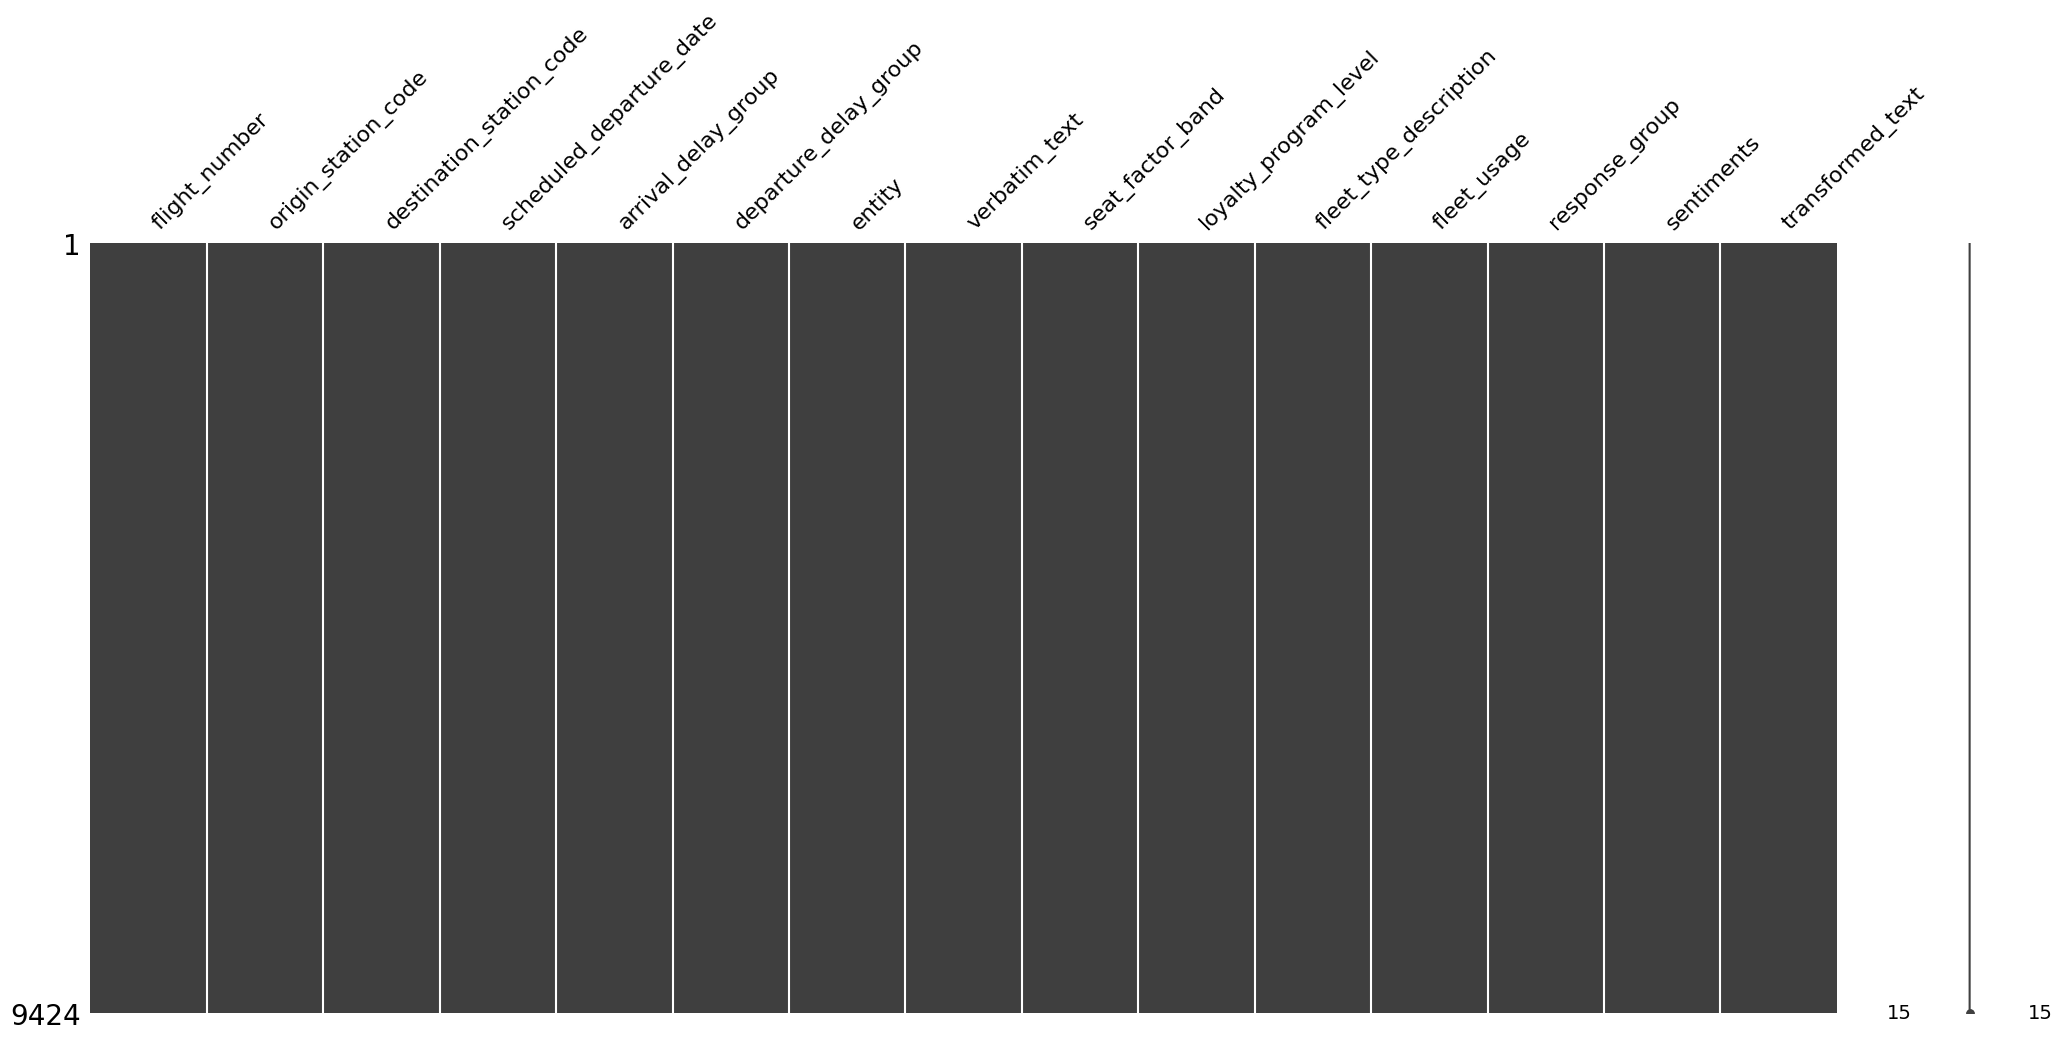

In [393]:
display(comments_df.isnull().sum())
display(msno.matrix(comments_df))

In [ ]:
comments_df.to_csv('processed_dataset/customer_comments.csv', index=False)

### Bookings Table Data Processing

#### Bookings Table Data Cleaning

In [395]:
bookings_df = pd.read_csv('raw_dataset/Passanger_booking_data.csv')

In [396]:
bookings_dupes = dedupe(bookings_df)
print(f'Duplicate Count: {bookings_dupes}')

Duplicate Count: 719


In [397]:
display(bookings_df.info())
display(bookings_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 49283 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49283 non-null  int64  
 1   sales_channel          49283 non-null  object 
 2   trip_type              49283 non-null  object 
 3   purchase_lead          49283 non-null  int64  
 4   length_of_stay         49283 non-null  int64  
 5   flight_hour            49283 non-null  int64  
 6   flight_day             49283 non-null  object 
 7   route                  49283 non-null  object 
 8   booking_origin         49283 non-null  object 
 9   wants_extra_baggage    49283 non-null  int64  
 10  wants_preferred_seat   49283 non-null  int64  
 11  wants_in_flight_meals  49283 non-null  int64  
 12  flight_duration        49283 non-null  float64
 13  booking_complete       49283 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


None

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000
mean,1.590204,84.723393,23.054197,9.070613,0.668222,0.295639,0.426638,7.279937,0.149991
std,1.016540,90.409389,33.831644,5.413007,0.470856,0.456334,0.494594,1.496381,0.357066
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.000000,5.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.000000,9.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.000000,13.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.000000,23.000000,1.000000,1.000000,1.000000,9.500000,1.000000


num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

<Axes: >

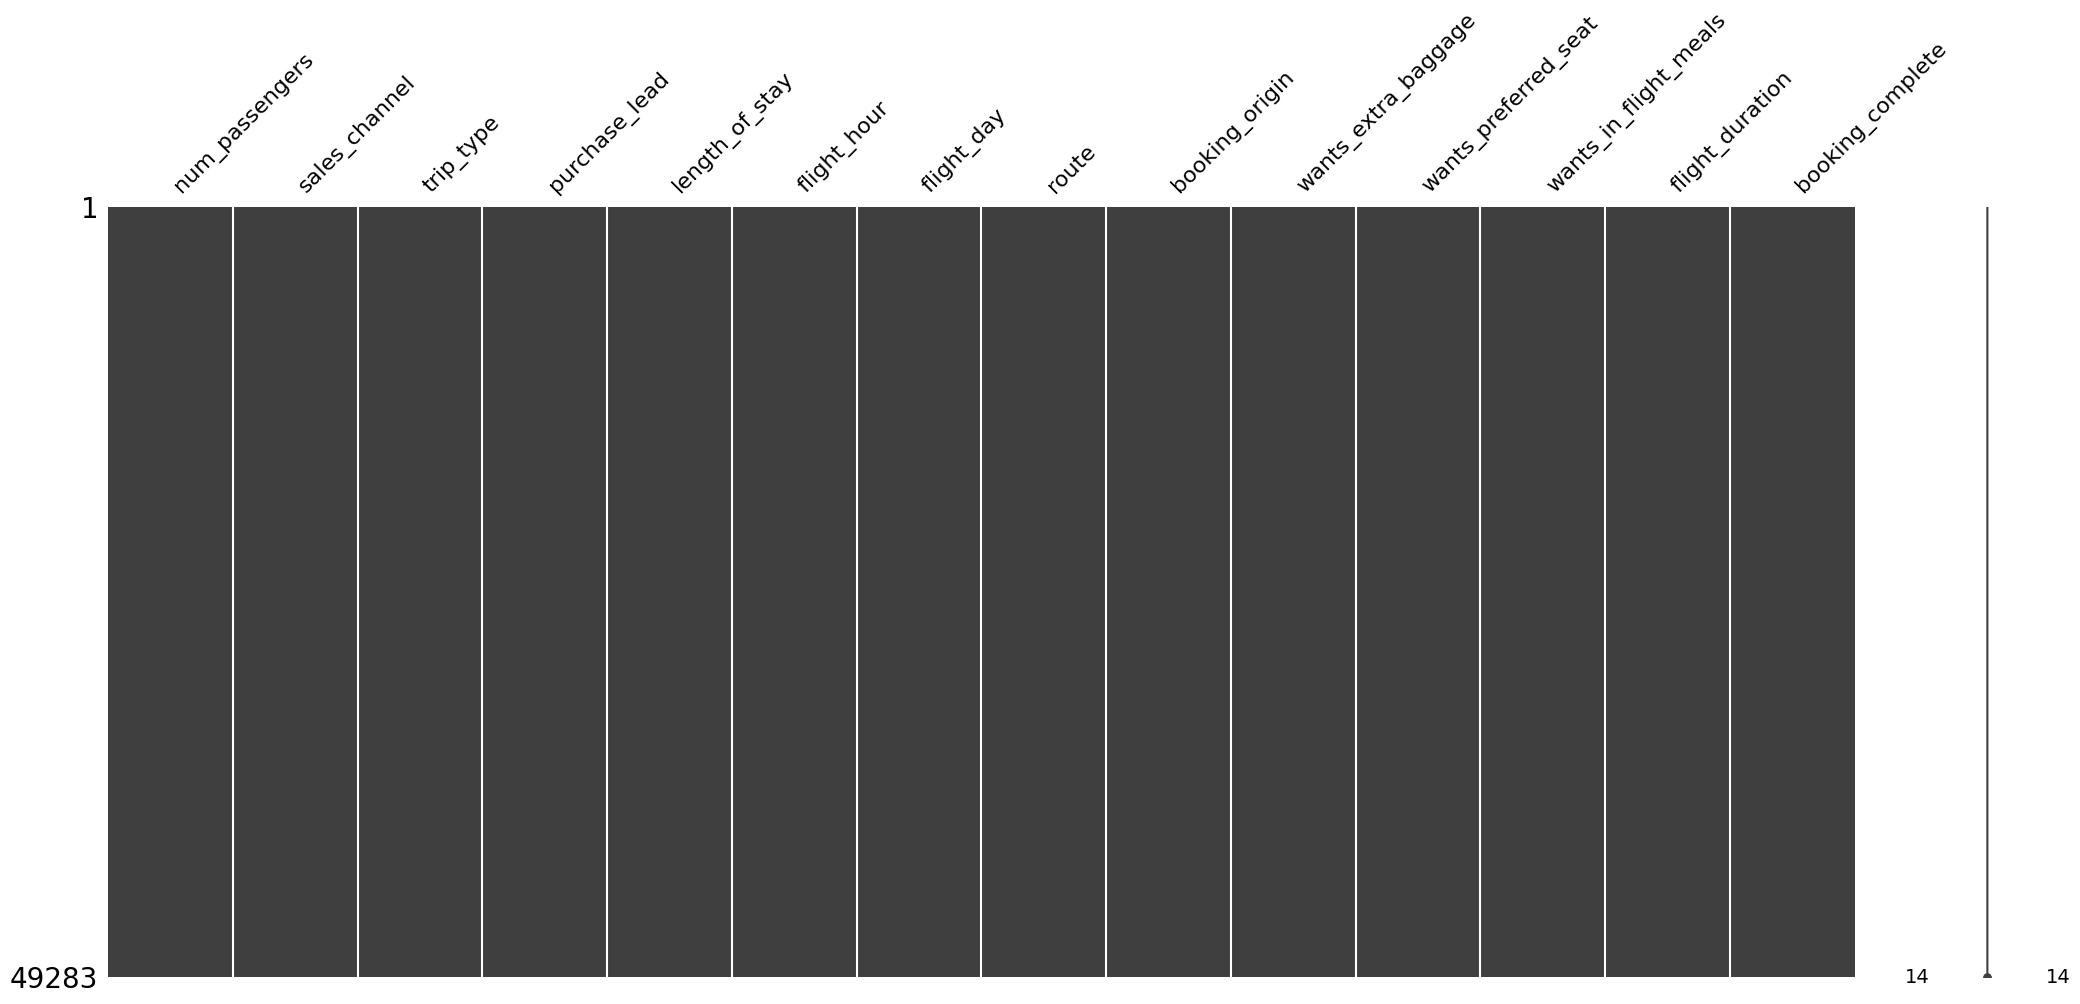

In [398]:
display(bookings_df.isnull().sum())
display(msno.matrix(bookings_df))

- Data is clean and sound, no fillings or droppings were made. Only deduplications.

In [ ]:
bookings_df.to_csv('processed_dataset/passenger_bookings.csv', index=False)

### Surveys Table Data Processing

#### Surveys Table Data Cleaning

In [400]:
surveys_df = pd.read_csv('raw_dataset/Survey data_Inflight Satisfaction Score.csv')

In [401]:
surveys_dupes = dedupe(surveys_df)
print(f'Duplicate Count: {surveys_dupes}')

Duplicate Count: 0


In [402]:
display(surveys_df.info())
display(surveys_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   flight_number                     47074 non-null  int64 
 1   origin_station_code               47074 non-null  object
 2   destination_station_code          47074 non-null  object
 3   record_locator                    47074 non-null  object
 4   scheduled_departure_date          47074 non-null  object
 5   question_text                     47074 non-null  object
 6   score                             47074 non-null  object
 7   satisfaction_type                 34963 non-null  object
 8   driver_sub_group1                 47074 non-null  object
 9   driver_sub_group2                 47074 non-null  object
 10  arrival_delay_minutes             47074 non-null  int64 
 11  arrival_delay_group               47074 non-null  object
 12  cabin_code_desc   

None

,flight_number,arrival_delay_minutes,number_of_legs,actual_flown_miles
count,47074.000000,47074.000000,47074.000000,47074.000000
mean,1529.855207,-1.702490,1.344118,2477.737732
std,1456.712299,37.868177,0.502424,1865.646538
min,2.000000,-104.000000,1.000000,45.000000
25%,477.000000,-19.000000,1.000000,932.000000
50%,1050.000000,-9.000000,1.000000,1846.000000
75%,2060.000000,4.000000,2.000000,3870.000000
max,6376.000000,907.000000,3.000000,8440.000000


flight_number                           0
origin_station_code                     0
destination_station_code                0
record_locator                          0
scheduled_departure_date                0
question_text                           0
score                                   0
satisfaction_type                   12111
driver_sub_group1                       0
driver_sub_group2                       0
arrival_delay_minutes                   0
arrival_delay_group                     0
cabin_code_desc                         0
cabin_name                          19980
entity                                  3
number_of_legs                          0
seat_factor_band                        0
loyalty_program_level               11616
generation                              0
fleet_type_description                  0
fleet_usage                             0
equipment_type_code                     0
ua_uax                                  0
actual_flown_miles                

<Axes: >

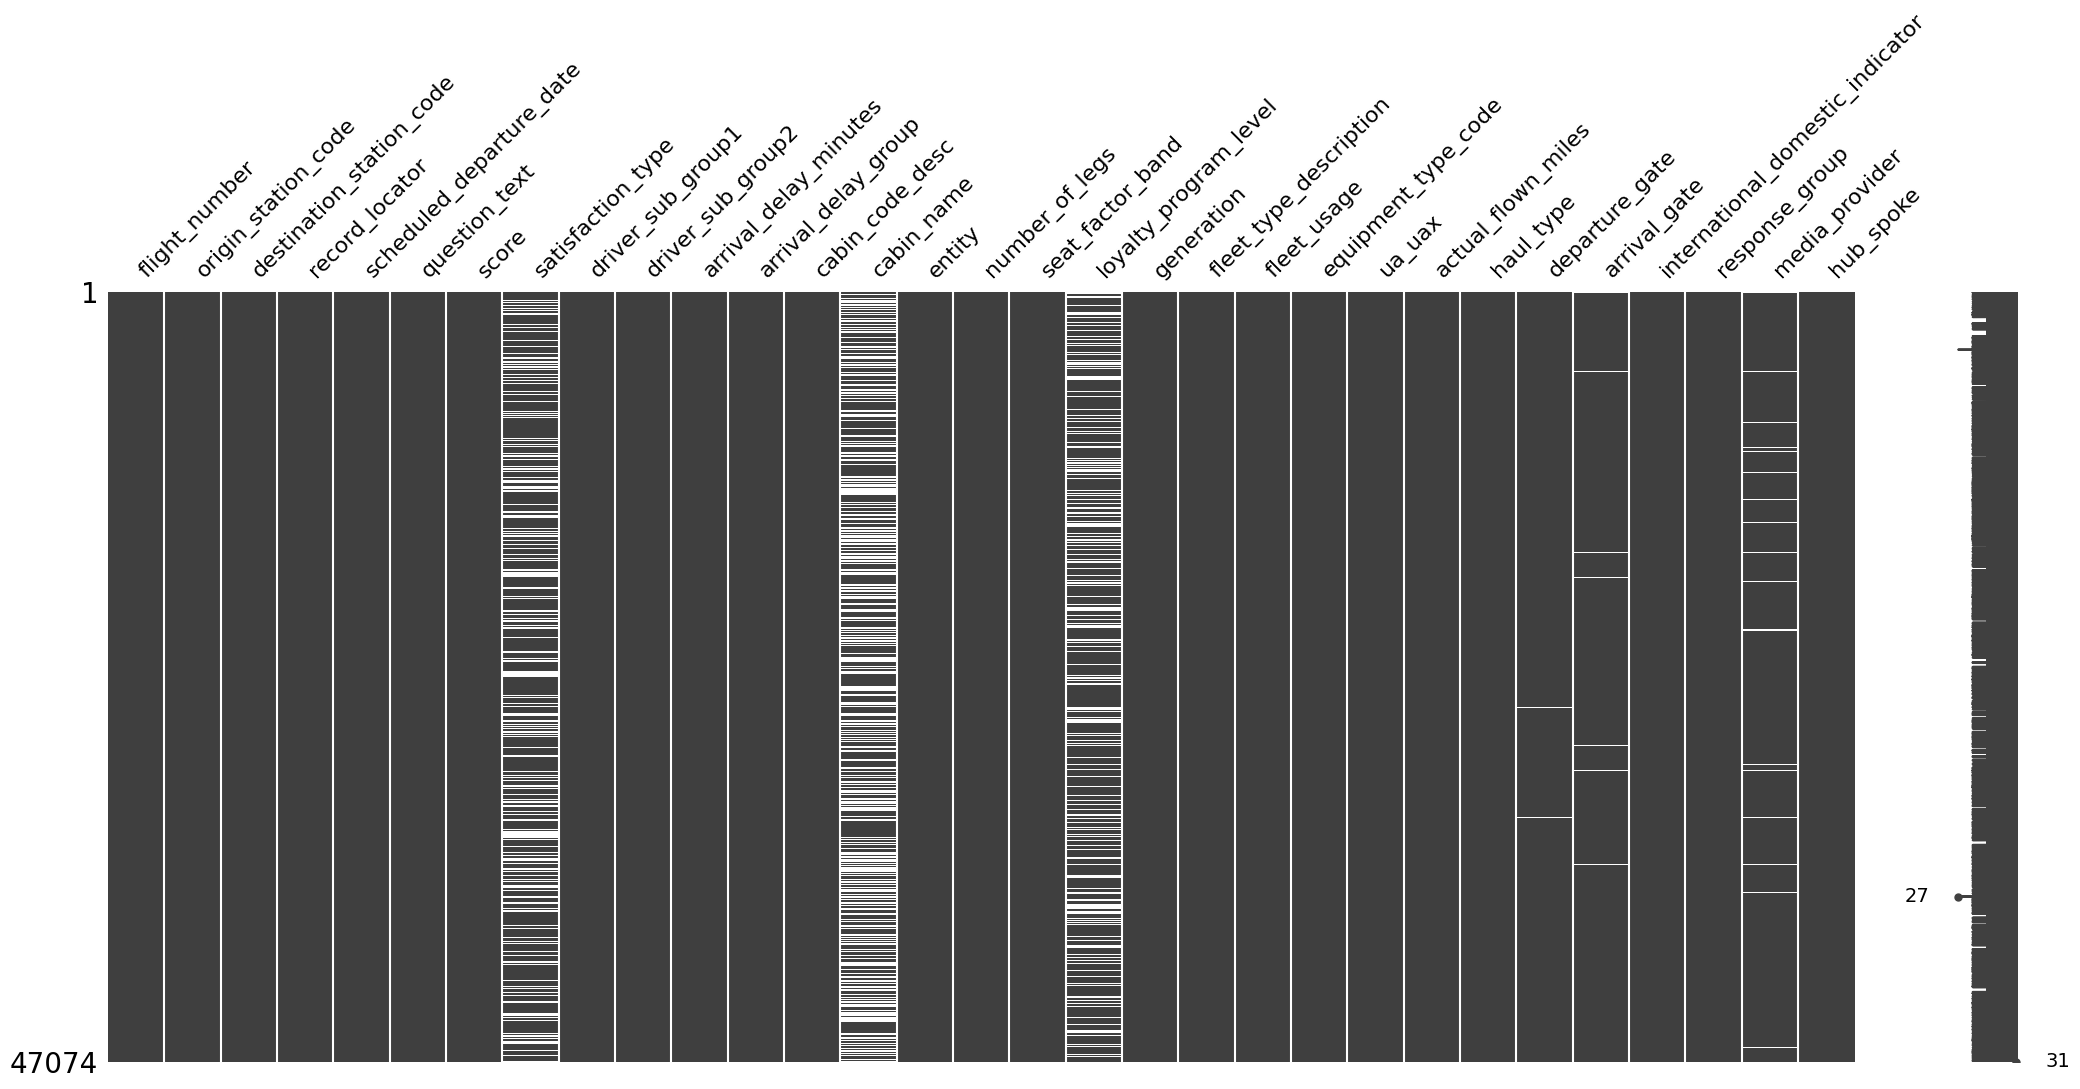

In [403]:
display(surveys_df.isnull().sum())
display(msno.matrix(surveys_df))